# Cluster Analysis

Getting a deep understanding of how customers use your mobility service is crucial. As an example, for marketing purposes, or managerial decisions. One widely adopted approach to understand customers’ behavior is to find prevalent usage/trip clusters. 

**Tasks:** Based on the taxi trip patterns, can you identify clusters of trip types and/or customer types? How would you label these clusters? 

**Methods:** Identify clusters with soft-clustering and visualize your results. Compare your results to a hard-clustering method of your choice. You can use additional features like “distance to city center”, expressive hourly resolutions (e.g., “bar hours”, “morning commuting”), or even land-use/POI data. 

Furthermore, can you identify spatial hot spots for trip demand using Gaussian Mixture Models (i.e., using Spatial Kernel Density Estimation)?

## 0.1 Data Loading & Preparation

### 0.1.1 Importing Packages and Loading the Data

In [1]:
# import all necessary packages
import pandas as pd
import numpy as np
import json
import datetime
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib as mlp
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
#from geopy.distance import great_circle
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from datetime import datetime
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

from sklearn import metrics
import math
from sklearn.metrics import mean_squared_error
sns.set_theme()

import sklearn
from sklearn.cluster import KMeans
import folium

In [2]:
# import datasets
dfChicago = pd.read_csv("data\datasets\df_chicago.csv.zip")

In [3]:
dfChicago.columns

Index(['Trip_ID', 'Taxi_ID', 'Trip_Start_Timestamp', 'Trip_End_Timestamp',
       'Trip_Seconds', 'Trip_Miles', 'Pickup_Census_Tract',
       'Dropoff_Census_Tract', 'Pickup_Community_Area',
       'Dropoff_Community_Area', 'Fare', 'Tips', 'Tolls', 'Extras',
       'Payment_Type', 'Pickup_Centroid_Latitude', 'Pickup_Centroid_Longitude',
       'Pickup_Centroid_Location', 'Dropoff_Centroid_Latitude',
       'Dropoff_Centroid_Longitude', 'Dropoff_Centroid__Location',
       'Community_Areas', 'Original_Trip_Start_Timestamp',
       'Original_Trip_End_Timestamp', 'date_start', 'dayOfWeek', 'isHoliday',
       'season', 'start_time_hourly', 'start_time_day', 'start_time_week',
       'start_time_month', 'isRushhour', 'velocity_(miles/h)', 'pressure',
       'datetime', 'humidity', 'temperature_celsius', 'wind_direction',
       'wind_speed', 'description', 'h3_hex_id_high_res',
       'h3_hex_id_medium_res', 'h3_hex_id_low_res'],
      dtype='object')

### 0.1.2 Additional Data Preparation

In [4]:
# insert code here
dfChicago_clustering = dfChicago[['Trip_ID', 'Taxi_ID', 'start_time_hourly','start_time_day', 'start_time_week', 'start_time_month','Trip_Seconds',"Trip_Miles", 'temperature_celsius',
                                  'Pickup_Centroid_Location', 'Dropoff_Centroid__Location', 'h3_hex_id_high_res', 'h3_hex_id_medium_res', 'h3_hex_id_low_res']]
dfChicago_clustering

,Trip_ID,Taxi_ID,start_time_hourly,start_time_day,start_time_week,start_time_month,Trip_Seconds,Trip_Miles,temperature_celsius,Pickup_Centroid_Location,Dropoff_Centroid__Location,h3_hex_id_high_res,h3_hex_id_medium_res,h3_hex_id_low_res
0,27ad87f629bf14fa3cb894daad514cdad4736f9c,4b38941e0745acdeefe630832a438a59fdaac78640f68a...,0,1,1,1,900.0,2.7,-0.19,POINT (-87.6635175498 41.874005383),POINT (-87.6333080367 41.899602111),882664ca91fffff,872664ca9ffffff,862664cafffffff
1,9a9d9902dfa267b88400a22a2c9f0cf74384b372,1a1189d1e9f4f676bbeaf49903912684b94453576a234f...,0,1,1,1,240.0,0.4,-0.19,POINT (-87.6561568309 41.9289672664),POINT (-87.6513108767 41.9290469366),882664c12bfffff,872664c12ffffff,862664c17ffffff
2,5e07d8d10a2314fb71214c71ca3f19beab79652d,0826a2682f598bf0e39aa460479bc87757bd2fcb72c171...,0,1,1,1,1920.0,0.6,-0.19,POINT (-87.6997544065 41.9211259143),POINT (-87.6840183712 41.9668340674),882664ca11fffff,872664ca1ffffff,862664ca7ffffff
3,6deda34a1a498737aaa64734fa2c09a0bf335f18,48c42d95f8331cbfbcab8a6d5299dbb654a041f3c2efff...,0,1,1,1,180.0,1.0,-0.19,POINT (-87.6763559892 41.90120699410001),POINT (-87.6763559892 41.90120699410001),882664cac3fffff,872664cacffffff,862664cafffffff
4,faa2c909d0b88f3f54217135c6919a7fdd73a366,2e75c09511f6a1e2dee45f65888243ab9093f6c1558f10...,0,1,1,1,240.0,0.3,-0.19,POINT (-87.642648998 41.8792550844),POINT (-87.6219716519 41.8774061234),882664c1adfffff,872664c1affffff,862664c1fffffff
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8974515,eda096d2b89a8b2b432642ec1e2a1a1fd72c4dd8,0f1b65c1c73b1a8a687054ea0bb175edd243a5d065d7fa...,23,31,1,12,540.0,1.4,-11.00,POINT (-87.6288741572 41.8920726347),POINT (-87.6499072264 41.9049353016),882664c1e1fffff,872664c1effffff,862664c1fffffff
8974516,9bb135881fb88cd37521eddacd3003d6e6642e8f,7b1ac8aace3932ce8b4302cc292a88c6d6f0446ea8134c...,23,31,1,12,1860.0,5.9,-11.00,POINT (-87.6262105324 41.8991556134),POINT (-87.640698076 41.9431550855),882664c1e1fffff,872664c1effffff,862664c1fffffff
8974517,e93c3a7ee7050521d22a6d513b65d94642813a4c,9a03b73c5ab73cff888abb6ee2eb598352e4168671bd7c...,23,31,1,12,720.0,2.0,-11.00,POINT (-87.6209929134 41.8849871918),POINT (-87.6173580061 41.859349715),882664c1e3fffff,872664c1effffff,862664c1fffffff
8974518,cf906408921ec94acfed42add2165ab0f52fe9b7,1e3120e8b2c9af9f006e47d546cc8cee6564dd40b15abe...,23,31,1,12,660.0,3.5,-11.00,POINT (-87.6129454143 41.8919715078),POINT (-87.6241352979 41.84924675450001),882664c1ebfffff,872664c1effffff,862664c1fffffff


## 1.1 Hard Clustering

In [5]:
# method for scaling the data 
def scaling_data(df1):
    
    scaler = StandardScaler()
    dfChicago_clu_X_locations_scaled = scaler.fit_transform(df1)
    dfChicago_clu_X_locations_scaled_df = pd.DataFrame(dfChicago_clu_X_locations_scaled, columns=df1.columns, 
                                            index=df1.index)
    
    return dfChicago_clu_X_locations_scaled_df



In [6]:
def get_clusters_and_losses(input_data):
    
    clusters_dfChicago_clu_X = []
    losses_dfChicago_clu_X = []

    for k in range(20):
        model_clu_X = KMeans(n_clusters=k+1,n_init=1)
        model_clu_X.fit(input_data)
        clusters_dfChicago_clu_X.append(k+1)
        losses_dfChicago_clu_X.append(model_clu_X.inertia_)
        
    return clusters_dfChicago_clu_X, losses_dfChicago_clu_X

In [7]:
# method to plot the most valuable number of clusters
def plot_best_fitting_number_of_clusters(input_data, title_info):
    
    fig = plt.figure(figsize=(16,8))

    plt.subplot(1, 2, 1)

    clusters, losses = get_clusters_and_losses(input_data)

    plt.plot(clusters, losses)
    plt.ylabel("Loss")
    plt.xlabel("Number of clusters")
    plt.title(f"Number of Clusters {title_info}")

    plt.subplot(1, 2, 2)

    plt.plot(clusters, losses)
    plt.ylabel("Loss")
    plt.xlabel("Number of clusters")
    plt.xlim([0,12])
    plt.title(f"Number of Clusters {title_info} - Deeper Look")

    plt.show()

In [8]:
def plot_information_about_clusters(df, feature_list, cluster_column):
    
    fig = plt.figure(figsize=(14, 18))
    
    for i in range(1, len(feature_list)+1):
        plt.subplot(np.floor(len(feature_list)/2).astype(int)+1, 2, i)
        sns.boxplot(y=df[feature_list[i-1]], 
                    x = df[cluster_column], 
                    palette="bright",
                    showmeans=True,
                    meanprops={"marker": "+",
                       "markeredgecolor": "black",
                       "markersize": "10"}).set_title("Cluster - " + feature_list[i-1]).set_fontsize('18')
        plt.tight_layout()
    
    plt.subplot(np.floor(len(feature_list)/2).astype(int)+1, 2, len(feature_list)+1)
    ax = sns.countplot(x=cluster_column, data=df, palette="bright")
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Amount")
    ax.set_title('Cluster - Amount',fontsize=18)
    fig.tight_layout()

    for container in ax.containers:
        ax.bar_label(container)

In [9]:
def get_quantiles_of_clusters(df, n_cluster, cluster_feature):
    
    # create dataframe to store values of calculated quantiles and return df at the end of the method
    dfChicago_quantiles = pd.DataFrame(df)
    # empty all values inside newly created df to just receive columns
    dfChicago_quantiles = dfChicago_quantiles[0:0]

    for cluster in range(0,n_cluster):
        # get 0.25 quantiles
        dict_quantiles_0_25 = df[df[cluster_feature]==cluster].quantile(q=0.25).to_dict()
        # get 0.75 quantiles
        dict_quantiles_0_75 = df[df[cluster_feature]==cluster].quantile(q=0.75).to_dict()
        # round all entries in dictionaries to one decimal place
        dfQuantiles_0_25 = pd.DataFrame(dict_quantiles_0_25, index=[0]).round(2)
        dfQuantiles_0_75 = pd.DataFrame(dict_quantiles_0_75, index=[0]).round(2)
        # parse all values in newly created dfs to strings
        dfQuantiles_0_25 = dfQuantiles_0_25.astype(str)
        dfQuantiles_0_75 = dfQuantiles_0_75.astype(str)
        # combine both quantile dataframes into one interval dataframe
        dfQuantiles_interval = dfQuantiles_0_25 + " - " + dfQuantiles_0_75
        dfQuantiles_interval['Amount Trips in Cluster'] = df[df[cluster_feature]==cluster][cluster_feature].count().astype(int)
        dfQuantiles_interval['Percentage'] = (df[df[cluster_feature]==cluster][cluster_feature].count()/len(df)).round(4)*100
        # concatenate the quantiles row after row
        dfChicago_quantiles = pd.concat([dfChicago_quantiles, dfQuantiles_interval.loc[dfQuantiles_interval.index.values == 0]])
        
    # lastly styling the output dataframe (dropping unnecessary column, resetting the index, giving "Cluster" as index column name)
    dfChicago_quantiles.drop(columns=[cluster_feature], inplace=True)
    dfChicago_quantiles.reset_index(drop=True, inplace=True)
    dfChicago_quantiles = dfChicago_quantiles.rename_axis('Cluster')    
    
    return dfChicago_quantiles

In [10]:
# Custom colors for clusters (sorted)
cluster_colors = ['#1f77b4',  # Blue
                  '#ff7f0e',  # Orange
                  '#2ca02c',  # Green
                  '#d62728',  # Red
                  '#9467bd',  # Purple
                  '#8c564b',  # Brown
                  '#e377c2',  # Pink
                  '#7f7f7f',  # Gray
                  '#bcbd22',  # Yellow
                  '#17becf']  # Cyan

# Function to create convex hull polygons for each cluster
def create_convex_hulls(df, x_col, y_col, cluster_col):
    convex_hulls = {}
    for cluster_id, cluster_data in df.groupby(cluster_col):
        points = cluster_data[[x_col, y_col]].values
        hull = ConvexHull(points)
        hull_points = points[hull.vertices]
        convex_hulls[cluster_id] = hull_points
    return convex_hulls

# Function to plot the scatter plot with convex hull boundaries and markers
def plot_scatter_with_hulls(df, x_col, y_col, cluster_col, label_col, size_tuple, dp_size, x_label, y_label, plot_title, leg_loc, anchor):
    # Create convex hulls
    convex_hulls = create_convex_hulls(df, x_col, y_col, cluster_col)
    
    # Plot the scatter plot with convex hull boundaries and markers
    plt.figure(figsize=size_tuple)
    for idx, (cluster_id, cluster_data) in enumerate(df.groupby(cluster_col)):
        color = cluster_colors[idx % len(cluster_colors)]  # Use custom colors cyclically
        hull_points = convex_hulls[cluster_id]
        hull_polygon = plt.Polygon(hull_points, alpha=0.2, facecolor=color, edgecolor=color, linewidth=2)
        plt.gca().add_patch(hull_polygon)
        
        inner_points = cluster_data.drop_duplicates([x_col, y_col]).loc[:, [x_col, y_col]]
        plt.scatter(inner_points[x_col], inner_points[y_col], label=cluster_data[label_col].iloc[0], s=dp_size, c=color)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(plot_title)
    plt.legend(loc=leg_loc, bbox_to_anchor=anchor) 
    plt.grid(True)
    plt.show()


### 1.1.1 Feature Selection - Hourly Start Time

In [11]:
# Feature selection
dfChicago_clu_start_time = dfChicago_clustering[['start_time_hourly']]
dfChicago_clu_start_time

,start_time_hourly
0,0
1,0
2,0
3,0
4,0
...,...
8974515,23
8974516,23
8974517,23
8974518,23


In [12]:
# Scaling the data
dfChicago_clu_start_time_scaled = scaling_data(dfChicago_clu_start_time)

### 1.1.2 Validation of Number of Clusters

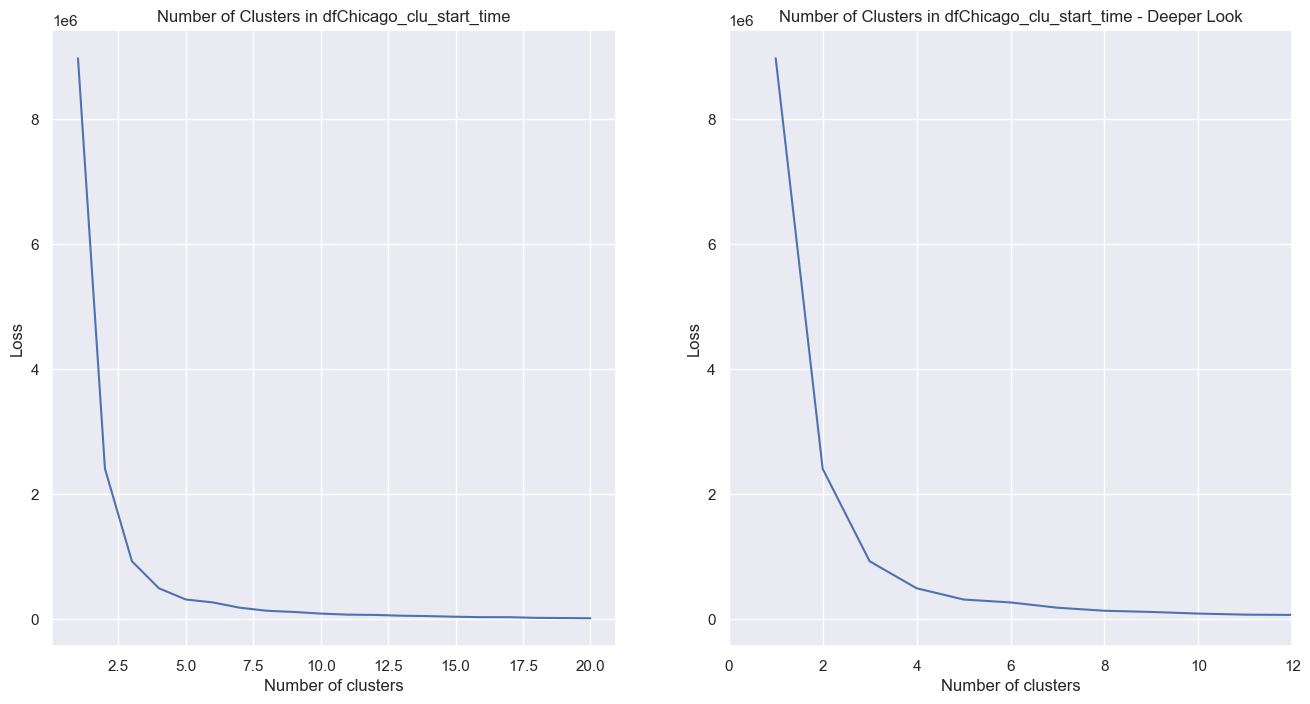

In [13]:
plot_best_fitting_number_of_clusters(dfChicago_clu_start_time_scaled, "in dfChicago_clu_start_time")

### 1.1.3 Computing Clusters with KMeans

In [14]:
# initializing our kmeans algorithm 
kmean = KMeans(n_clusters=3,init='k-means++', random_state=42)

# fitting our scaled data to the model
kmean.fit(dfChicago_clu_start_time_scaled)

c:\Users\jonas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=3, random_state=42)

In [15]:
# store the predicted clusters 
Clusters = kmean.predict(dfChicago_clu_start_time_scaled)

In [16]:
# creating a column for the calculated clusters

dfChicago_clu_start_time.loc[:, 'cluster_number'] = Clusters
dfChicago_clu_start_time

C:\Users\jonas\AppData\Local\Temp\ipykernel_14484\1040107666.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfChicago_clu_start_time.loc[:, 'cluster_number'] = Clusters


,start_time_hourly,cluster_number
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
8974515,23,0
8974516,23,0
8974517,23,0
8974518,23,0


### 1.1.4 Analyzing Clusters & Labeling them

In [17]:
dfChicago_clu_start_time[dfChicago_clu_start_time['cluster_number']==0]['cluster_number'].count()

4195483

C:\Users\jonas\AppData\Local\Temp\ipykernel_14484\1267026547.py:21: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


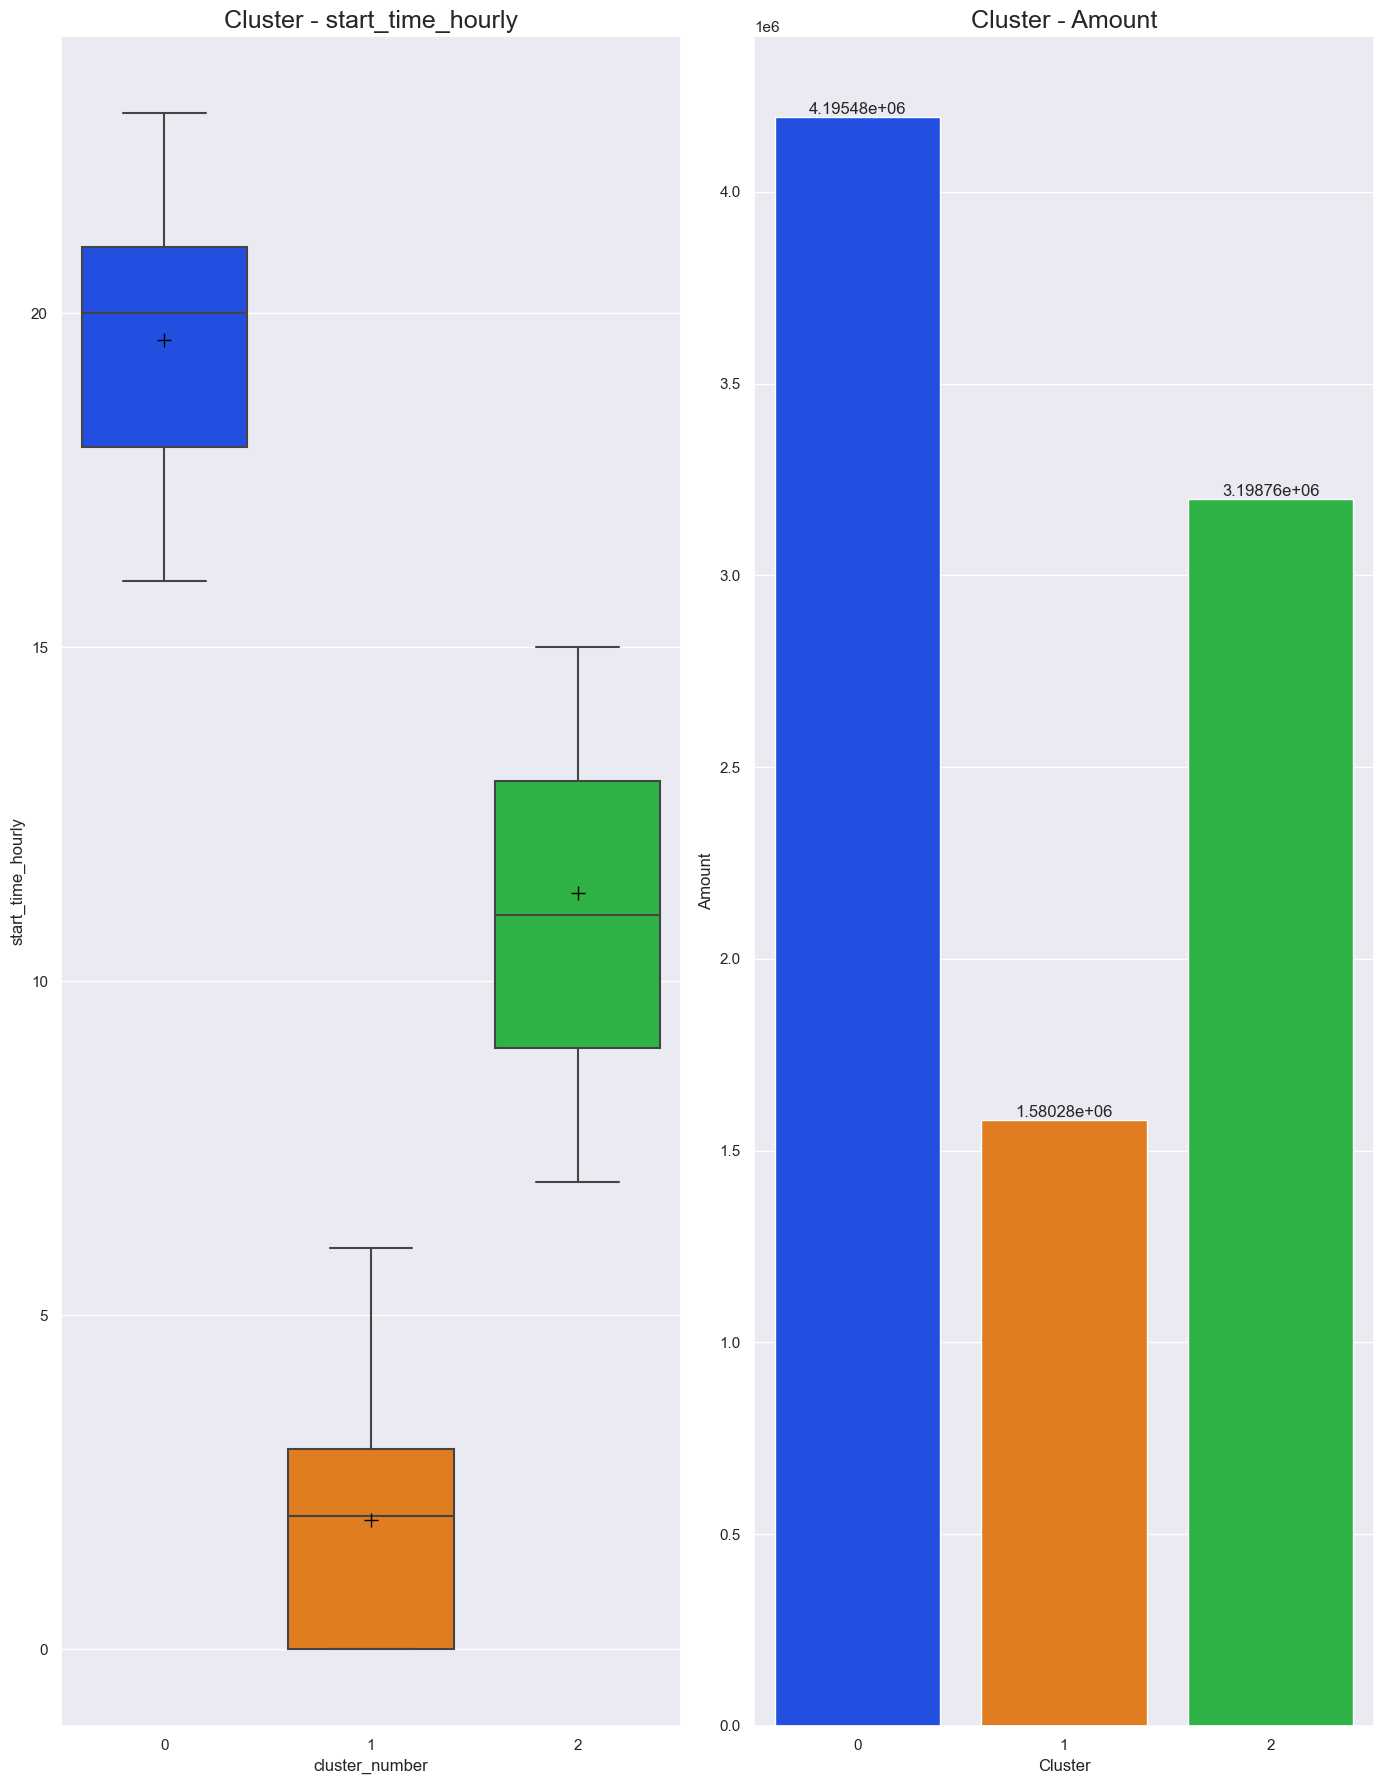

In [18]:
plot_information_about_clusters(dfChicago_clu_start_time, ['start_time_hourly'], 'cluster_number')

In [19]:
dfChicago_clu_start_time_quantiles = get_quantiles_of_clusters(dfChicago_clu_start_time, 3, 'cluster_number')
dfChicago_clu_start_time_quantiles.sort_values(by=['start_time_hourly'], ascending=False)

,start_time_hourly,Amount Trips in Cluster,Percentage
Cluster,,,
2,9.0 - 13.0,3198762.0,35.64
0,18.0 - 21.0,4195483.0,46.75
1,0.0 - 3.0,1580275.0,17.61


In [20]:
label_names = {'0': "Evening Commuters", 
               '1': "Night Riders - Party People",
               '2': "Morning Commuters"}

# integrating our labeled clusters in the dataframe
dfChicago_clu_start_time['Cluster_Label'] = dfChicago_clu_start_time['cluster_number'].astype(str)
dfChicago_clu_start_time = dfChicago_clu_start_time.replace({"Cluster_Label": label_names})

C:\Users\jonas\AppData\Local\Temp\ipykernel_14484\788367742.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfChicago_clu_start_time['Cluster_Label'] = dfChicago_clu_start_time['cluster_number'].astype(str)


In [21]:
dfChicago_clu_start_time_index = dfChicago_clu_start_time
dfChicago_clu_start_time_index['Trip_Index'] = dfChicago_clu_start_time_index.index
dfChicago_clu_start_time_index

,start_time_hourly,cluster_number,Cluster_Label,Trip_Index
0,0,1,Night Riders - Party People,0
1,0,1,Night Riders - Party People,1
2,0,1,Night Riders - Party People,2
3,0,1,Night Riders - Party People,3
4,0,1,Night Riders - Party People,4
...,...,...,...,...
8974515,23,0,Evening Commuters,8974515
8974516,23,0,Evening Commuters,8974516
8974517,23,0,Evening Commuters,8974517
8974518,23,0,Evening Commuters,8974518


### 1.1.5 Plotting the Clustering Results

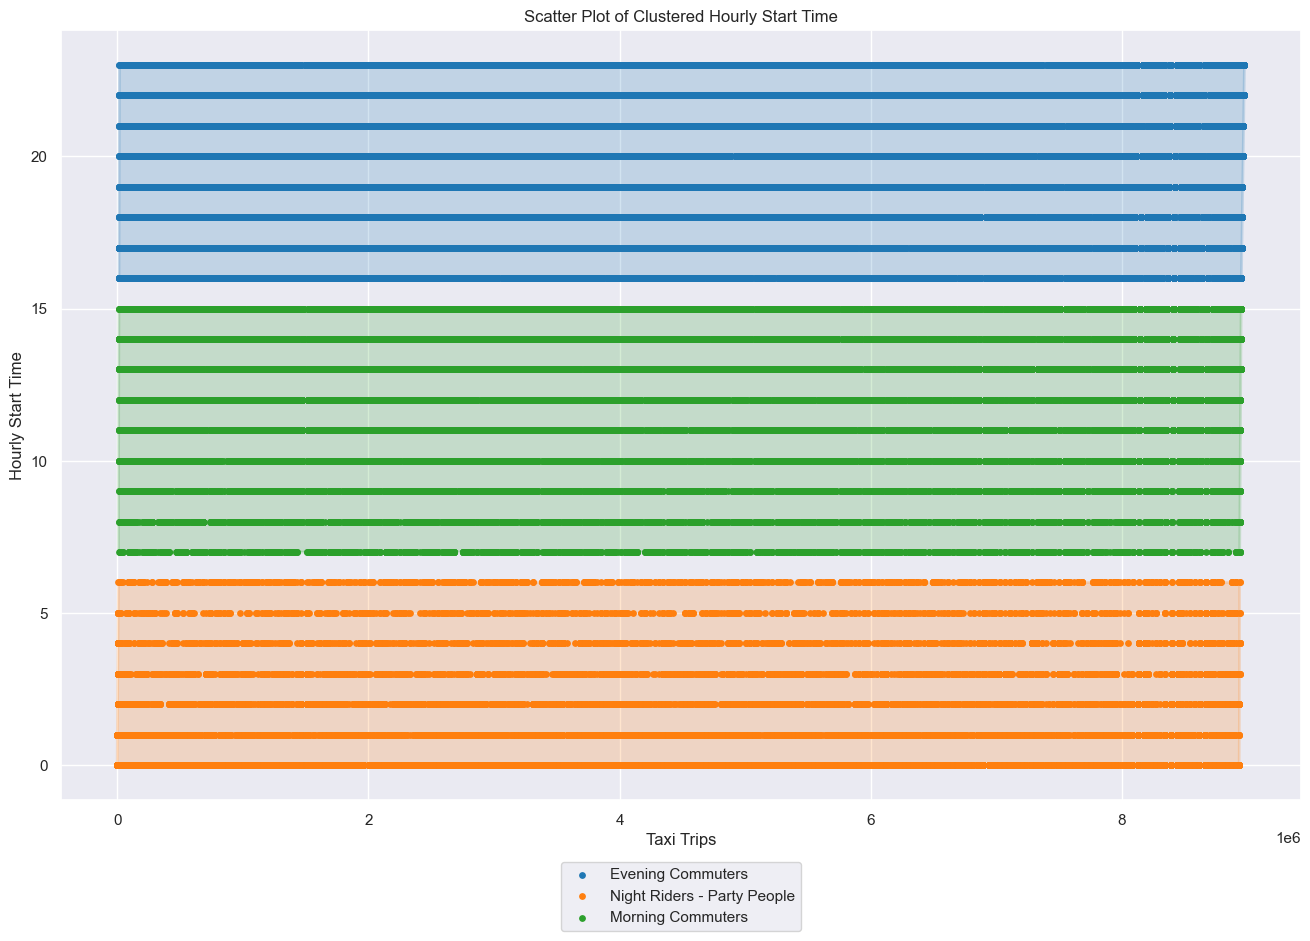

In [22]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(dfChicago_clu_start_time_index.sample(n=100000), x_col='Trip_Index', y_col='start_time_hourly', cluster_col='cluster_number', label_col="Cluster_Label", size_tuple=(16, 10), 
                        dp_size=15, x_label='Taxi Trips', y_label="Hourly Start Time", plot_title='Scatter Plot of Clustered Hourly Start Time', leg_loc='lower center', anchor=(0.5, -0.18))

### 1.2.1 Feature Selection - Trip Duration

In [23]:
# Feature selection
dfChicago_clu_trip_seconds = dfChicago_clustering[['Trip_Seconds']]
dfChicago_clu_trip_seconds

,Trip_Seconds
0,900.0
1,240.0
2,1920.0
3,180.0
4,240.0
...,...
8974515,540.0
8974516,1860.0
8974517,720.0
8974518,660.0


In [24]:
# Scaling the data
dfChicago_clu_trip_seconds_scaled = scaling_data(dfChicago_clu_trip_seconds)

### 1.2.2 Validation of Number of Clusters

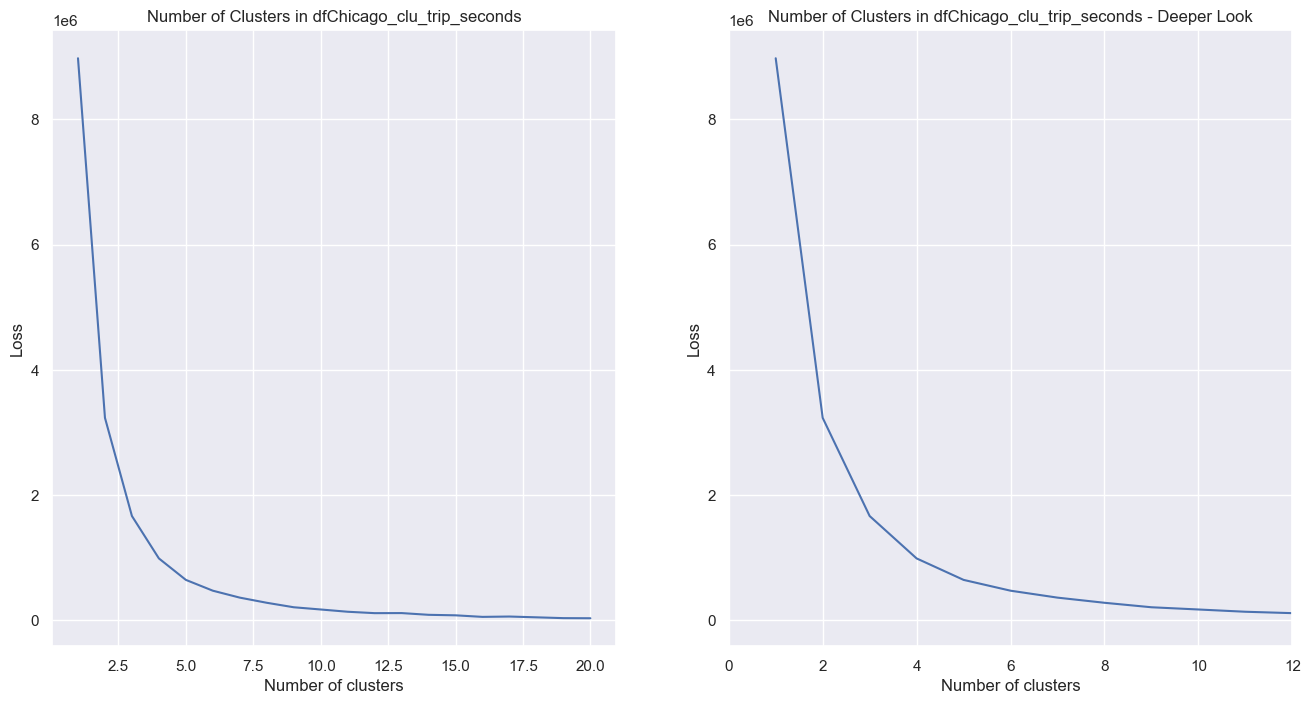

In [25]:
plot_best_fitting_number_of_clusters(dfChicago_clu_trip_seconds_scaled, "in dfChicago_clu_trip_seconds")

### 1.2.3 Computing Clusters with KMeans

In [26]:
# initializing our kmeans algorithm 
kmean = KMeans(n_clusters=4,init='k-means++', random_state=42)

# fitting our scaled data to the model
kmean.fit(dfChicago_clu_trip_seconds_scaled)

c:\Users\jonas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=4, random_state=42)

In [27]:
# store the predicted clusters 
Clusters = kmean.predict(dfChicago_clu_trip_seconds_scaled)

In [28]:
# creating a column for the calculated clusters

dfChicago_clu_trip_seconds.loc[:, 'cluster_number'] = Clusters
dfChicago_clu_trip_seconds

C:\Users\jonas\AppData\Local\Temp\ipykernel_14484\3771237839.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfChicago_clu_trip_seconds.loc[:, 'cluster_number'] = Clusters


,Trip_Seconds,cluster_number
0,900.0,1
1,240.0,0
2,1920.0,2
3,180.0,0
4,240.0,0
...,...,...
8974515,540.0,3
8974516,1860.0,2
8974517,720.0,3
8974518,660.0,3


### 1.2.4 Analyzing Clusters & Labeling them

In [29]:
dfChicago_clu_trip_seconds[dfChicago_clu_trip_seconds['cluster_number']==0]['cluster_number'].count()

3858665

C:\Users\jonas\AppData\Local\Temp\ipykernel_14484\1267026547.py:21: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


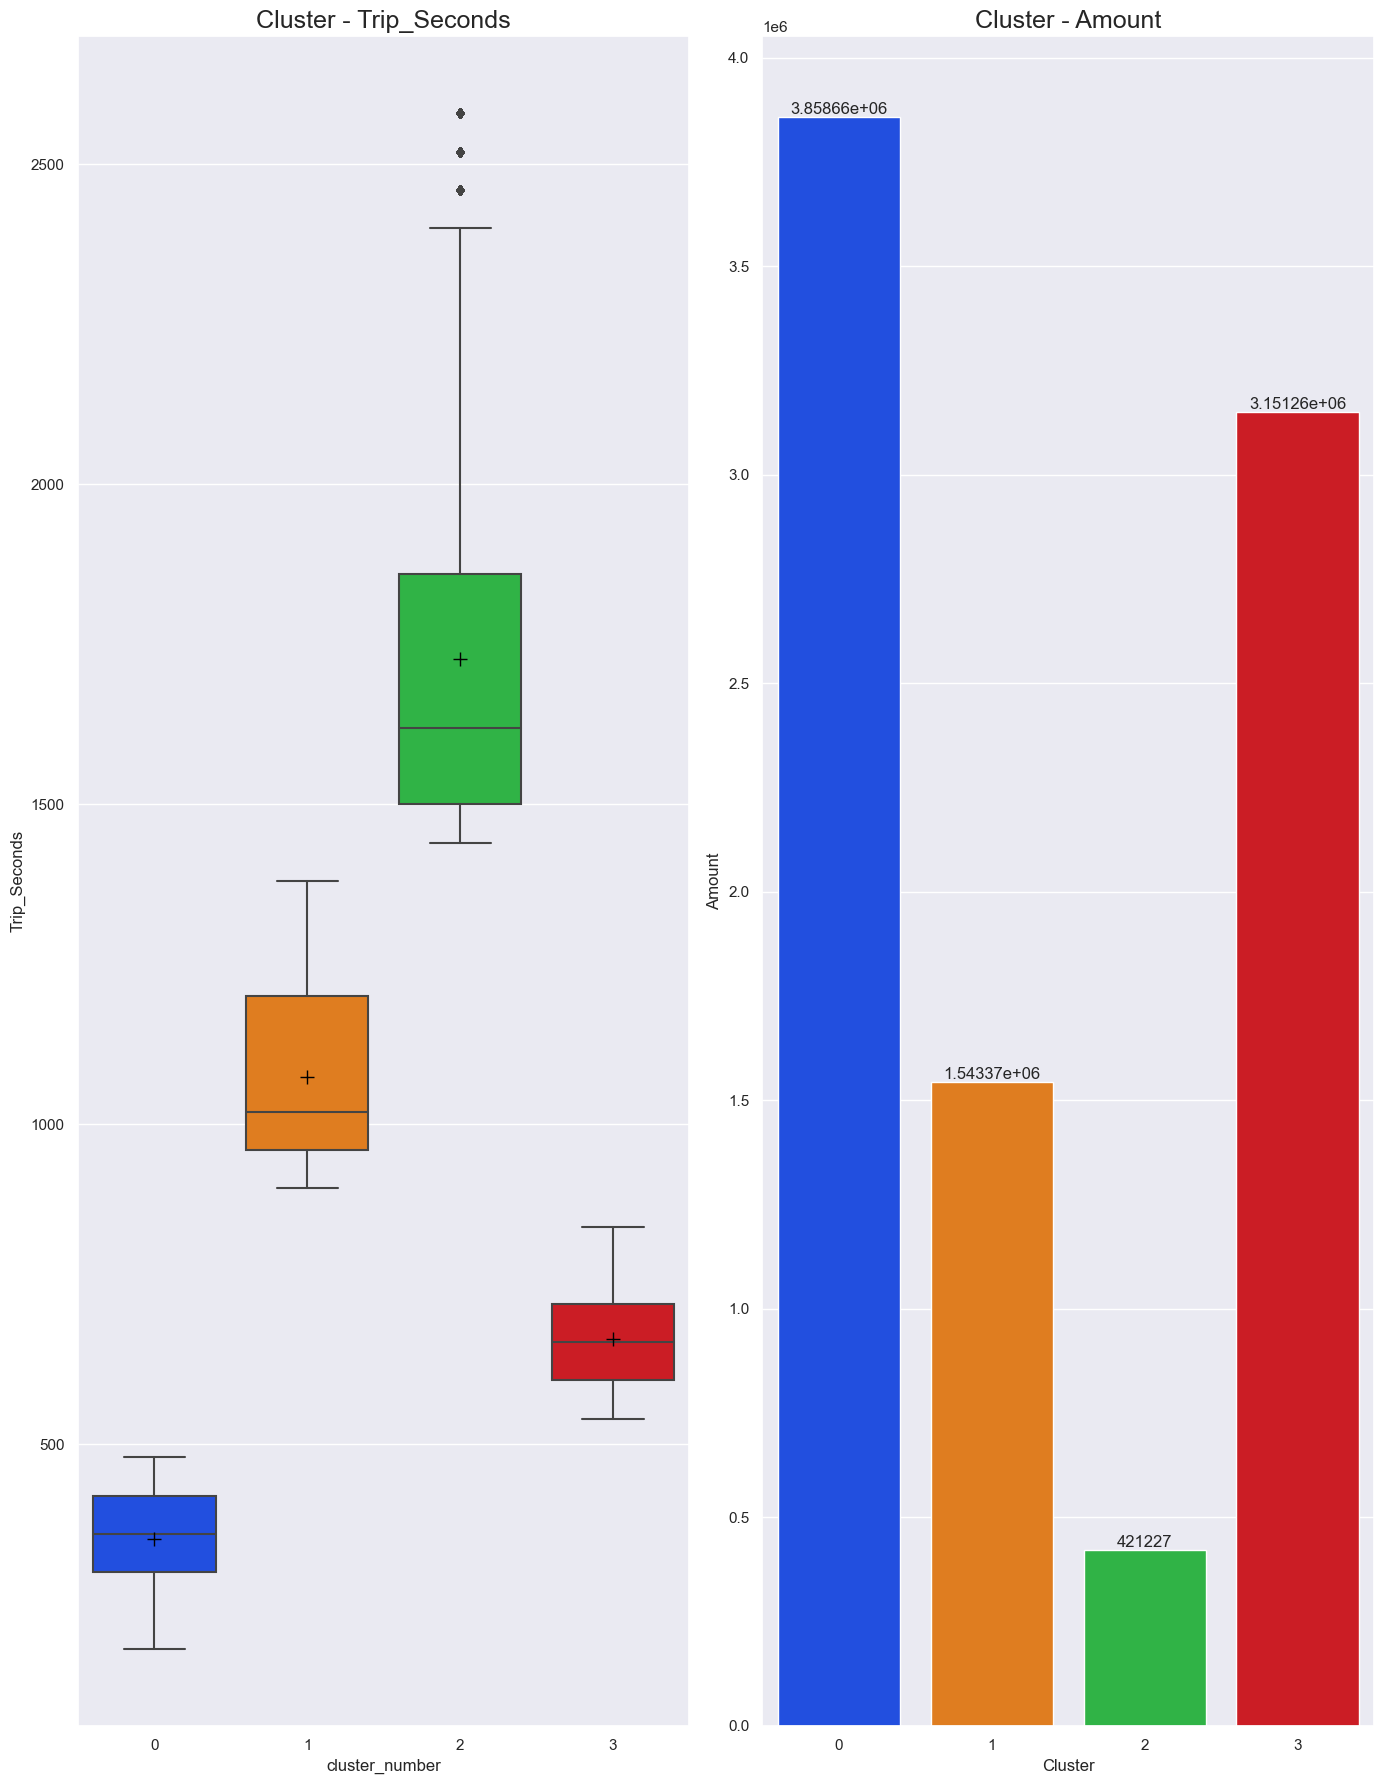

In [30]:
plot_information_about_clusters(dfChicago_clu_trip_seconds, ['Trip_Seconds'], 'cluster_number')

In [31]:
dfChicago_clu_trip_seconds_quantiles = get_quantiles_of_clusters(dfChicago_clu_trip_seconds, 4, 'cluster_number')
dfChicago_clu_trip_seconds_quantiles.sort_values(by=['Trip_Seconds'], ascending=False)


,Trip_Seconds,Amount Trips in Cluster,Percentage
Cluster,,,
1,960.0 - 1200.0,1543373.0,17.20
3,600.0 - 720.0,3151255.0,35.11
0,300.0 - 420.0,3858665.0,43.00
2,1500.0 - 1860.0,421227.0,4.69


In [32]:
label_names = {'0': "Short Trips", 
               '1': "Medium-to-Long Trips",
               '2': "Long Trips",
               '3': "Short-to-Medium Trips"}

# integrating our labeled clusters in the dataframe
dfChicago_clu_trip_seconds['Cluster_Label'] = dfChicago_clu_trip_seconds['cluster_number'].astype(str)
dfChicago_clu_trip_seconds = dfChicago_clu_trip_seconds.replace({"Cluster_Label": label_names})

C:\Users\jonas\AppData\Local\Temp\ipykernel_14484\3827503235.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfChicago_clu_trip_seconds['Cluster_Label'] = dfChicago_clu_trip_seconds['cluster_number'].astype(str)


In [33]:
dfChicago_clu_trip_seconds_index = dfChicago_clu_trip_seconds
dfChicago_clu_trip_seconds_index['Trip_Index'] = dfChicago_clu_trip_seconds_index.index
dfChicago_clu_trip_seconds_index

,Trip_Seconds,cluster_number,Cluster_Label,Trip_Index
0,900.0,1,Medium-to-Long Trips,0
1,240.0,0,Short Trips,1
2,1920.0,2,Long Trips,2
3,180.0,0,Short Trips,3
4,240.0,0,Short Trips,4
...,...,...,...,...
8974515,540.0,3,Short-to-Medium Trips,8974515
8974516,1860.0,2,Long Trips,8974516
8974517,720.0,3,Short-to-Medium Trips,8974517
8974518,660.0,3,Short-to-Medium Trips,8974518


### 1.2.5 Plotting the Clustering Results

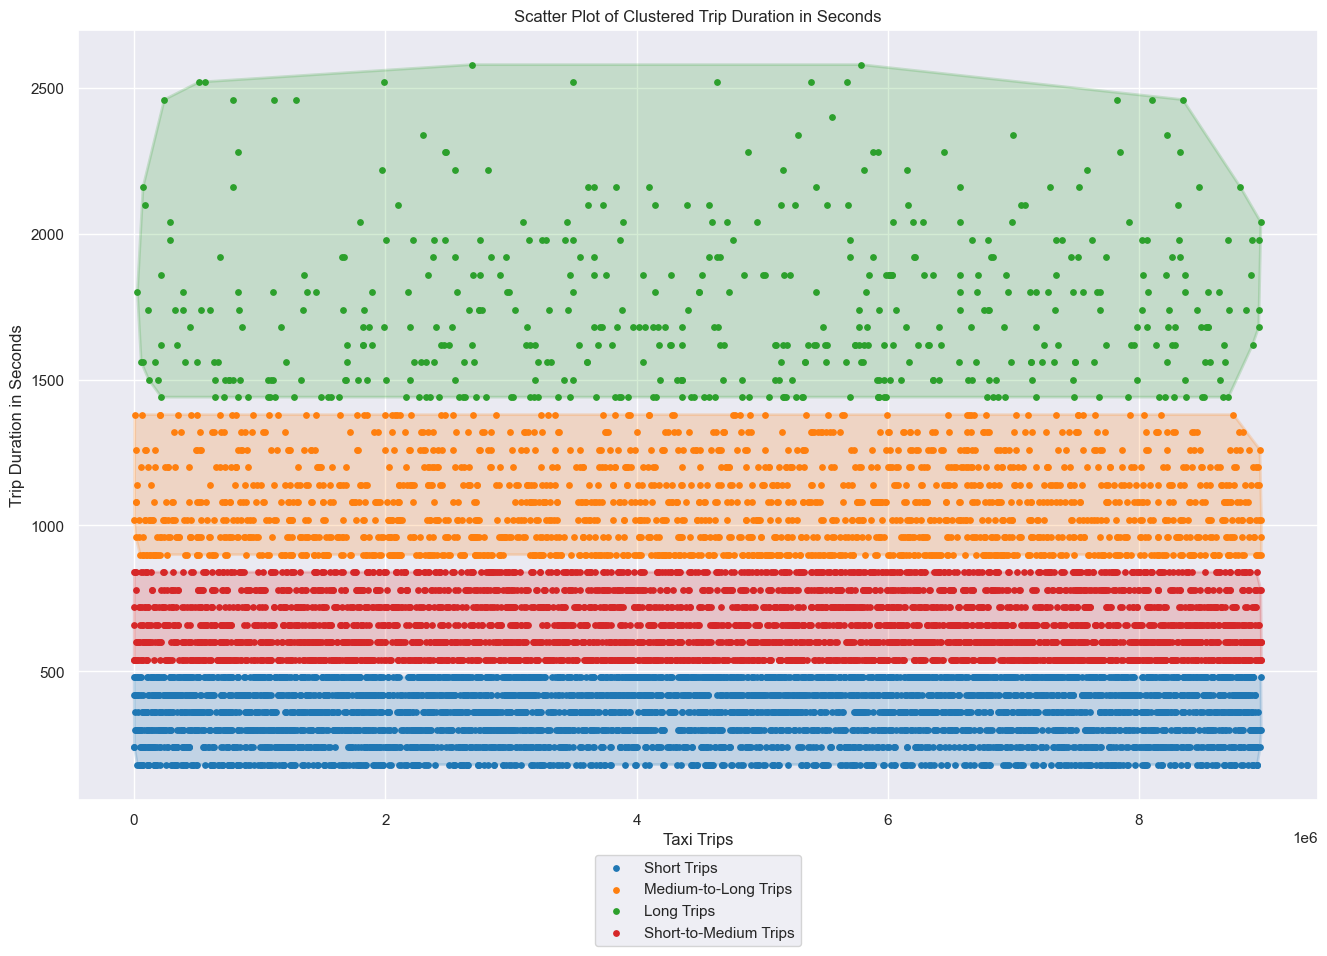

In [34]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(dfChicago_clu_trip_seconds_index.sample(n=10000), x_col='Trip_Index', y_col='Trip_Seconds', cluster_col='cluster_number', label_col="Cluster_Label", size_tuple=(16, 10), 
                        dp_size=15, x_label='Taxi Trips', y_label="Trip Duration in Seconds", plot_title='Scatter Plot of Clustered Trip Duration in Seconds', leg_loc='lower center', anchor=(0.5, -0.2))

### 1.3.1 Feature Selection - Trip Length in Miles

In [35]:
# Feature selection
dfChicago_clu_trip_miles = dfChicago_clustering[['Trip_Miles']]
dfChicago_clu_trip_miles

,Trip_Miles
0,2.7
1,0.4
2,0.6
3,1.0
4,0.3
...,...
8974515,1.4
8974516,5.9
8974517,2.0
8974518,3.5


In [36]:
# Scaling the data
dfChicago_clu_trip_miles_scaled = scaling_data(dfChicago_clu_trip_miles)

### 1.3.2 Validation of Number of Clusters

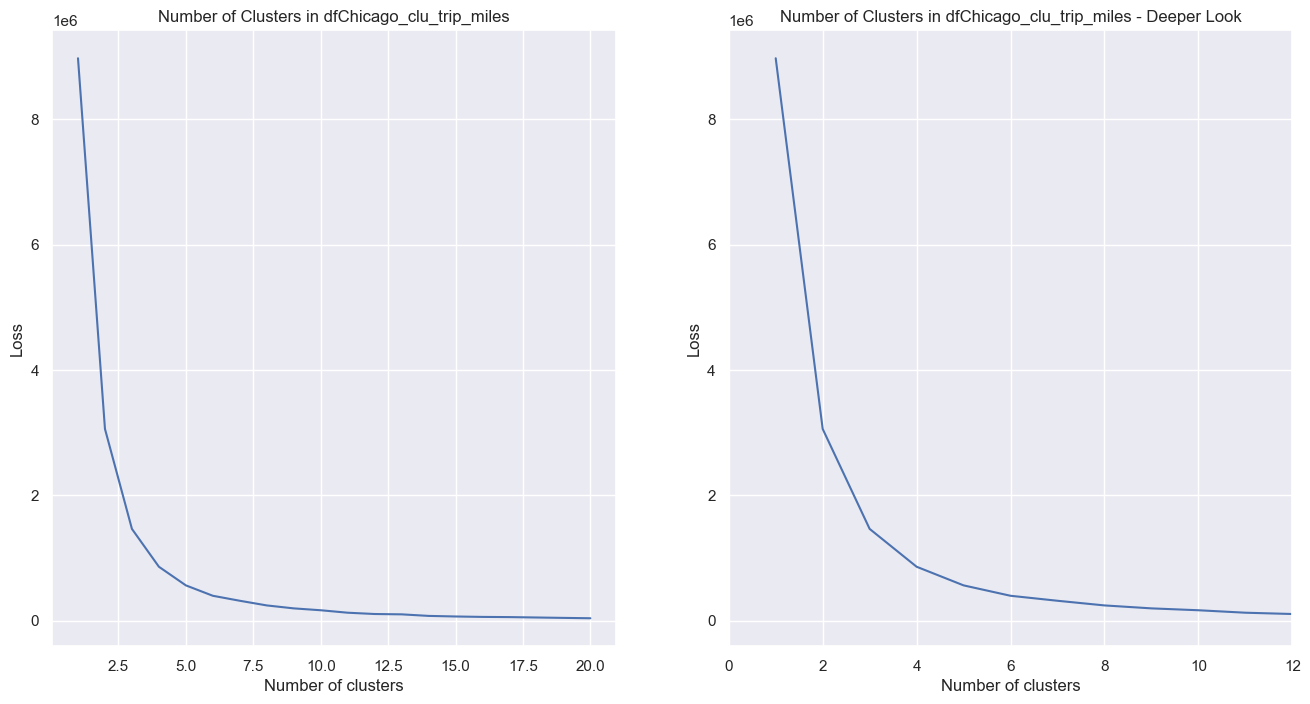

In [37]:
plot_best_fitting_number_of_clusters(dfChicago_clu_trip_miles_scaled, "in dfChicago_clu_trip_miles")

### 1.3.3 Computing Clusters with KMeans

In [38]:
# initializing our kmeans algorithm 
kmean = KMeans(n_clusters=4,init='k-means++', random_state=42)

# fitting our scaled data to the model
kmean.fit(dfChicago_clu_trip_miles_scaled)

# store the predicted clusters 
Clusters = kmean.predict(dfChicago_clu_trip_miles_scaled)

c:\Users\jonas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [39]:
# creating a column for the calculated clusters

dfChicago_clu_trip_miles.loc[:, 'cluster_number'] = Clusters
dfChicago_clu_trip_miles

C:\Users\jonas\AppData\Local\Temp\ipykernel_14484\3326964530.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfChicago_clu_trip_miles.loc[:, 'cluster_number'] = Clusters


,Trip_Miles,cluster_number
0,2.7,3
1,0.4,0
2,0.6,0
3,1.0,0
4,0.3,0
...,...,...
8974515,1.4,0
8974516,5.9,1
8974517,2.0,3
8974518,3.5,3


### 1.3.4 Analyzing Clusters & Labeling them

In [40]:
dfChicago_clu_trip_miles[dfChicago_clu_trip_miles['cluster_number']==0]['cluster_number'].count()

5197044

C:\Users\jonas\AppData\Local\Temp\ipykernel_14484\1267026547.py:21: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


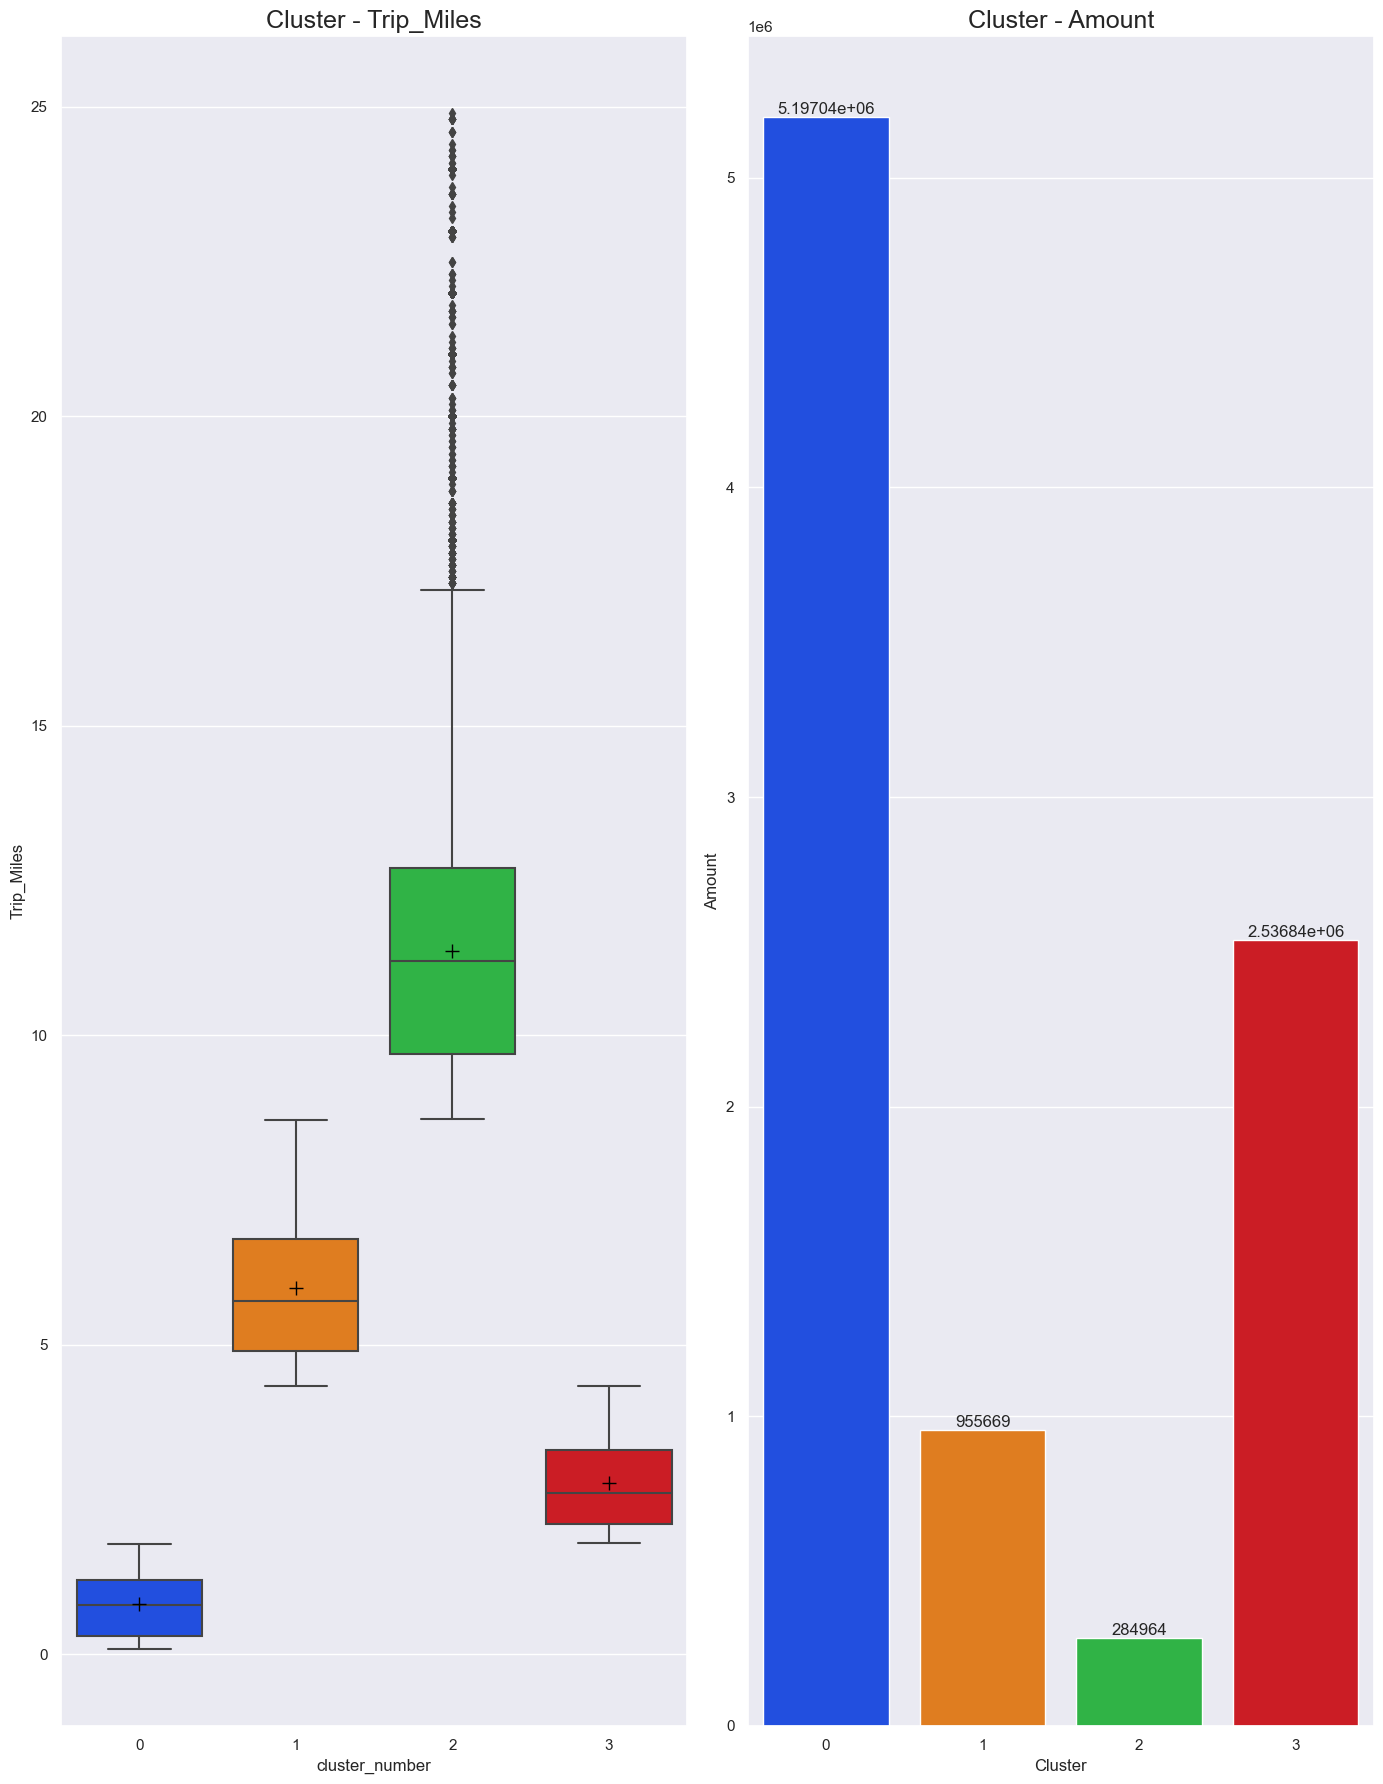

In [41]:
plot_information_about_clusters(dfChicago_clu_trip_miles, ['Trip_Miles'], 'cluster_number')

In [42]:
dfChicago_clu_trip_miles_quantiles = get_quantiles_of_clusters(dfChicago_clu_trip_miles, 4, 'cluster_number')
dfChicago_clu_trip_miles_quantiles.sort_values(by=['Trip_Miles'], ascending=False)

,Trip_Miles,Amount Trips in Cluster,Percentage
Cluster,,,
2,9.7 - 12.7,284964.0,3.18
1,4.9 - 6.7,955669.0,10.65
3,2.1 - 3.3,2536843.0,28.27
0,0.3 - 1.2,5197044.0,57.91


In [43]:
label_names = {'0': "Short Trips", 
               '1': "Medium-to-Long Trips",
               '2': "Long Trips",
               '3': "Short-to-Medium Trips"}

# integrating our labeled clusters in the dataframe
dfChicago_clu_trip_miles['Cluster_Label'] = dfChicago_clu_trip_miles['cluster_number'].astype(str)
dfChicago_clu_trip_miles = dfChicago_clu_trip_miles.replace({"Cluster_Label": label_names})

C:\Users\jonas\AppData\Local\Temp\ipykernel_14484\2890661011.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfChicago_clu_trip_miles['Cluster_Label'] = dfChicago_clu_trip_miles['cluster_number'].astype(str)


In [44]:
dfChicago_clu_trip_miles_index = dfChicago_clu_trip_miles
dfChicago_clu_trip_miles_index['Trip_Index'] = dfChicago_clu_trip_miles_index.index
dfChicago_clu_trip_miles_index

,Trip_Miles,cluster_number,Cluster_Label,Trip_Index
0,2.7,3,Short-to-Medium Trips,0
1,0.4,0,Short Trips,1
2,0.6,0,Short Trips,2
3,1.0,0,Short Trips,3
4,0.3,0,Short Trips,4
...,...,...,...,...
8974515,1.4,0,Short Trips,8974515
8974516,5.9,1,Medium-to-Long Trips,8974516
8974517,2.0,3,Short-to-Medium Trips,8974517
8974518,3.5,3,Short-to-Medium Trips,8974518


### 1.3.5 Plotting the Clustering Results

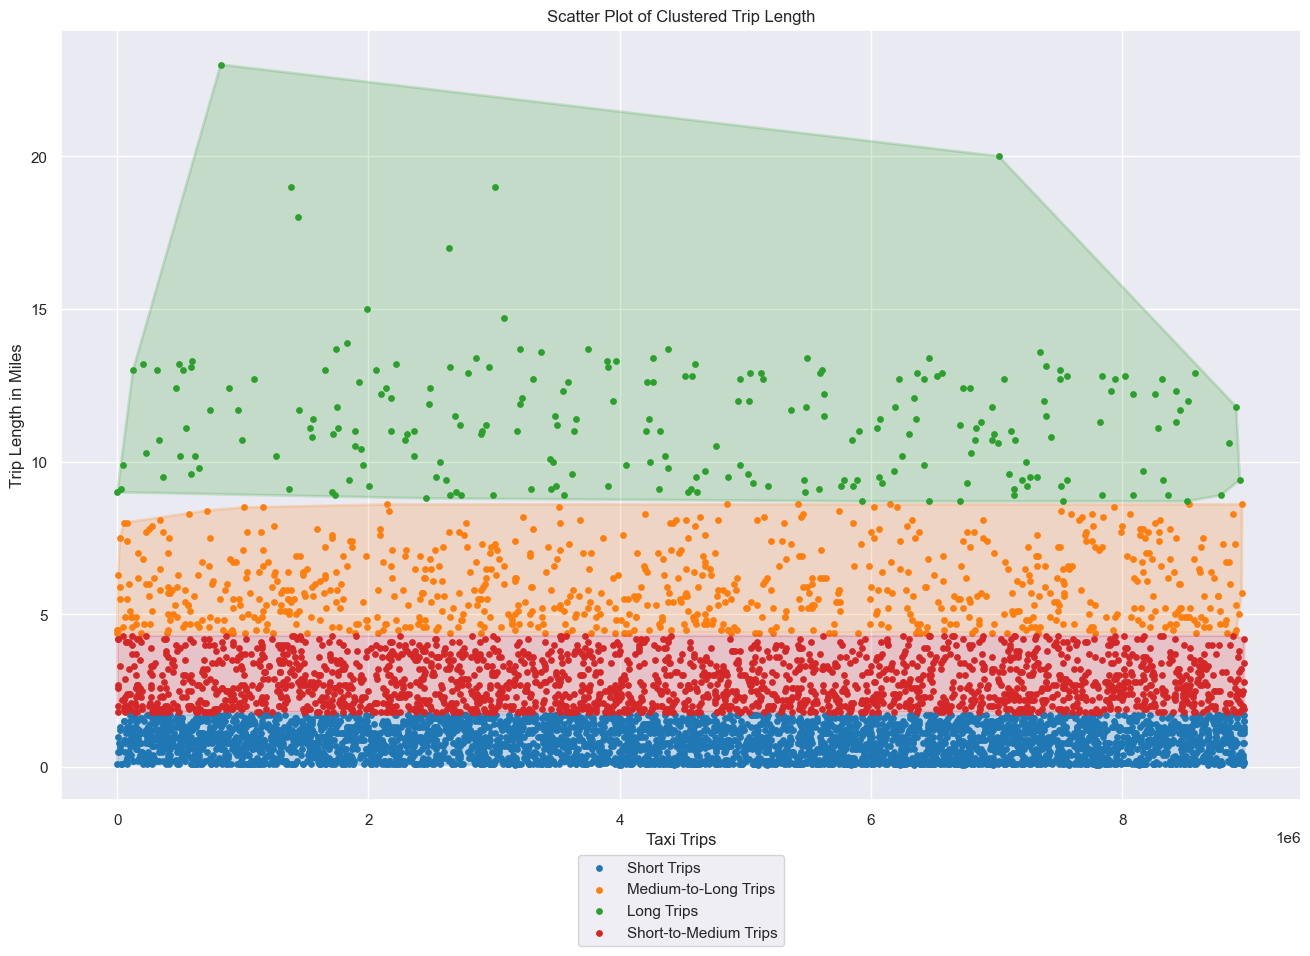

In [45]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(dfChicago_clu_trip_miles_index.sample(n=7000), x_col='Trip_Index', y_col='Trip_Miles', cluster_col='cluster_number', label_col="Cluster_Label", size_tuple=(16, 10), 
                        dp_size=15, x_label='Taxi Trips', y_label="Trip Length in Miles", plot_title='Scatter Plot of Clustered Trip Length', leg_loc='lower center', anchor=(0.5, -0.2))